In [1]:
%pip install statsmodels ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# ARMA and ARIMA Models 

In [2]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Simulate ARMA process (1,1) 

In [3]:
ar1 = np.array([1, 0.33])
ma1 = np.array([1, 0.9])

simulated_ARMA_data = ArmaProcess(ar1, ma1).generate_sample(nsample=10000)

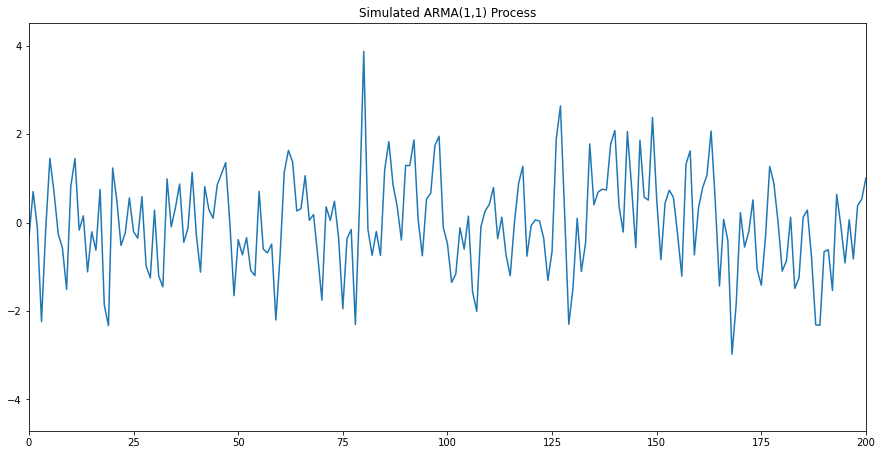

In [4]:
plt.figure(figsize=[15, 7.5]) # Set dimensions for figure
plt.plot(simulated_ARMA_data)
plt.title("Simulated ARMA(1,1) Process")
plt.xlim([0, 200])
plt.show()

''

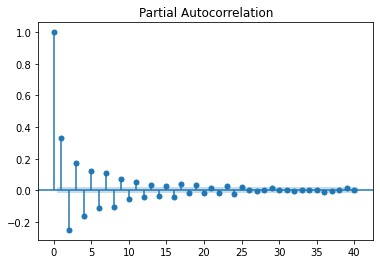

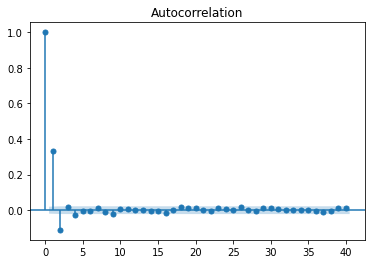

In [24]:
plot_pacf(simulated_ARMA_data)
plot_acf(simulated_ARMA_data)
""

## Simulate ARMA (2,2) process 

In [6]:
ar2 = np.array([1, 0.33, 0.5])
ma2 = np.array([1, 0.9, 0.3])

simulated_ARMA2_data = ArmaProcess(ar1, ma1).generate_sample(nsample=10000)

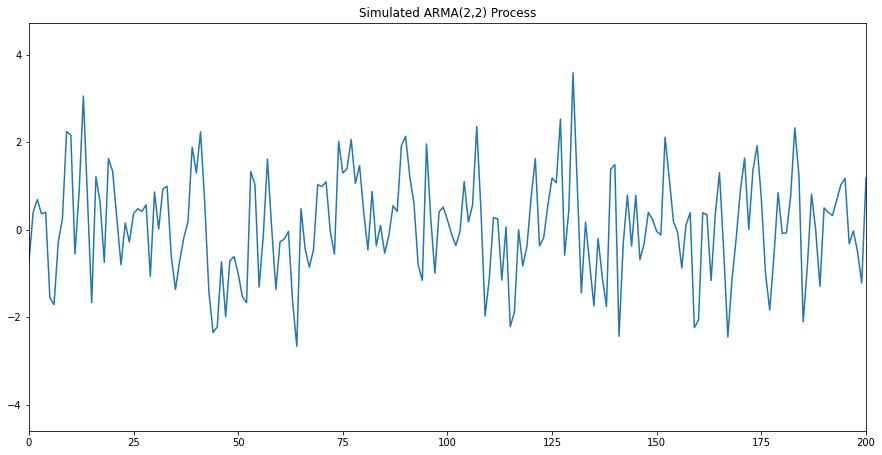

In [7]:
plt.figure(figsize=[15, 7.5]) # Set dimensions for figure
plt.plot(simulated_ARMA2_data)
plt.title("Simulated ARMA(2,2) Process")
plt.xlim([0, 200])
plt.show()

''

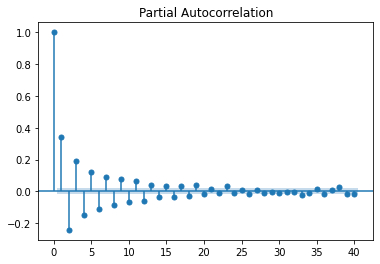

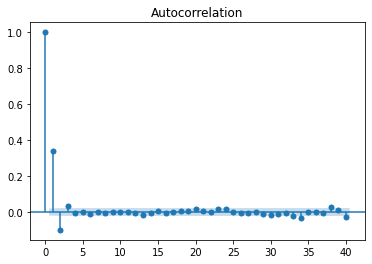

In [26]:
plot_pacf(simulated_ARMA2_data)
plot_acf(simulated_ARMA2_data)
""

## ARIMA of EPS data of a company in the share market

In [52]:
data=pd.read_csv('final.csv', usecols=[0,1,2],header=None, parse_dates=[2], engine='python')

df = data.groupby(2).sum()
print(type(df))
data = pd.DataFrame(zip(df.index,df.values[:,0]),columns=['date','data'])
print(data)


#Y=X.values[:,1:]

#X.head()
#X.shape

<class 'pandas.core.frame.DataFrame'>
          date  data
0   2018-01-02    60
1   2018-01-03   176
2   2018-01-06    43
3   2018-01-08    14
4   2018-01-10    40
..         ...   ...
743 2020-12-23    70
744 2020-12-24    36
745 2020-12-28     6
746 2020-12-29    18
747 2020-12-30    40

[748 rows x 2 columns]


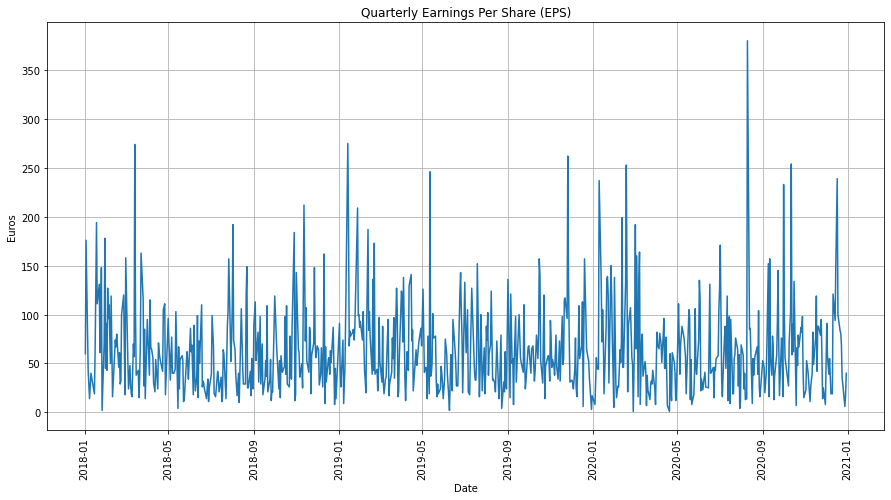

In [53]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['date'], data['data'])
plt.title('Quarterly Earnings Per Share (EPS)')
plt.ylabel('Euros')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

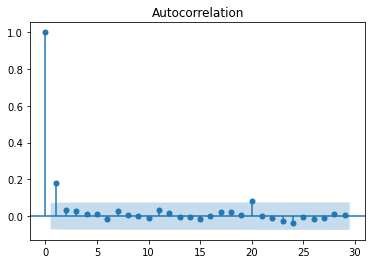

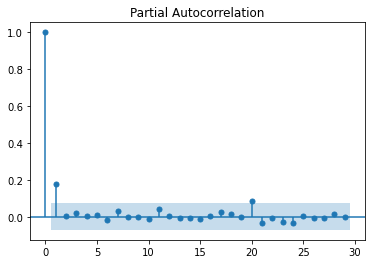

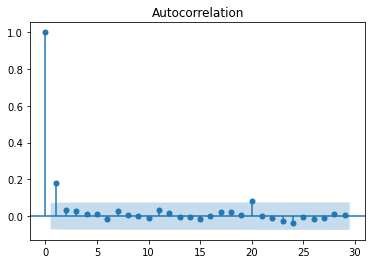

In [54]:
plot_pacf(data['data'])
plot_acf(data['data'])

In [55]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -22.787182171917603
p-value: 0.0


In [56]:
# Take the log difference to make data stationary

#data['data'] = np.log(data['data'])
#data['data'] = data['data'].diff()
#data = data.drop(data.index[0])
#data.head()

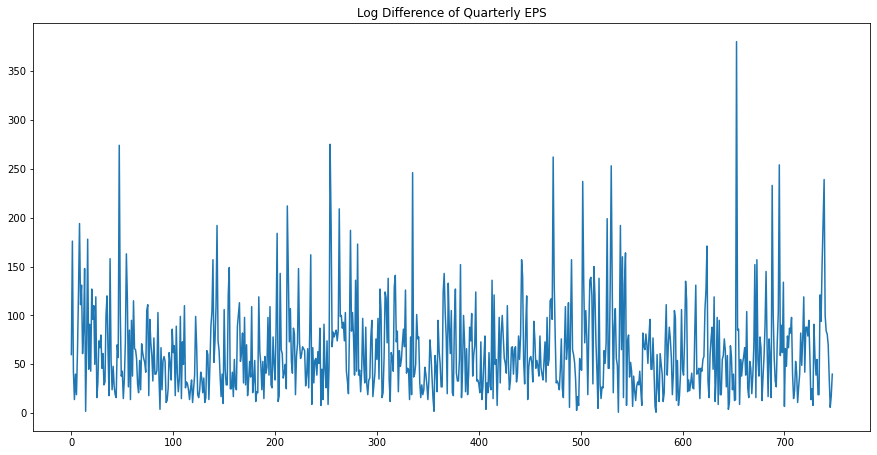

In [57]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS")
plt.show()

In [58]:
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -22.787182171917603
p-value: 0.0


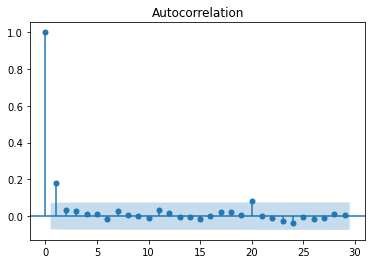

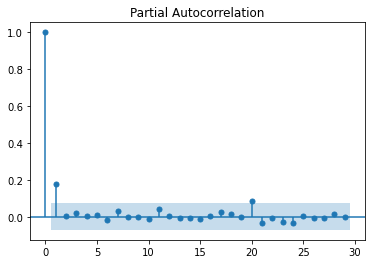

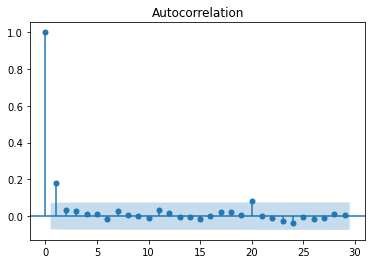

In [59]:
plot_pacf(data['data'])
plot_acf(data['data'])

In [60]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [61]:
## Set the grid search parameters
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=data['data'])

result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(3, 1, 3)",7837.099388
1,"(1, 1, 1)",7837.386047
2,"(2, 1, 4)",7838.141119
3,"(0, 1, 2)",7838.180437
4,"(2, 1, 2)",7839.290002
...,...,...
59,"(4, 1, 0)",7954.871399
60,"(3, 1, 0)",7978.493848
61,"(2, 1, 0)",8012.653832
62,"(1, 1, 0)",8083.747442


In [62]:
best_model = SARIMAX(data['data'], order=(4,1,1)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                  748
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -3915.480
Date:                Tue, 25 Jan 2022   AIC                           7842.960
Time:                        11:58:21   BIC                           7870.656
Sample:                             0   HQIC                          7853.634
                                - 748                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1787      0.036      4.994      0.000       0.109       0.249
ar.L2          0.0009      0.042      0.022      0.983      -0.082       0.084
ar.L3          0.0232      0.040      0.579      0.5

In [63]:
# Ljung-Box test and Augmented Dickey-Fuller test
#ljung_box, p_value = acorr_ljungbox(best_model.resid)
#
#print(f'Ljung-Box test: {ljung_box[:10]}')
#print(f'p-value: {p_value[:10]}')

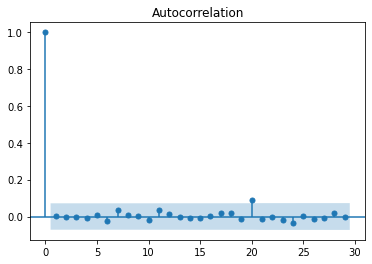

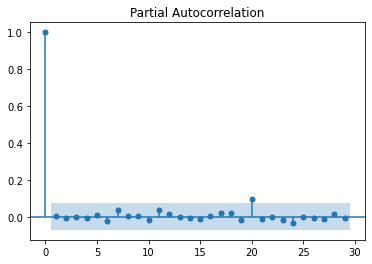

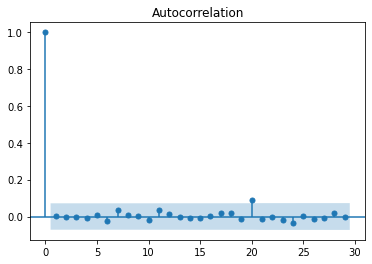

In [64]:
plot_pacf(best_model.resid)
plot_acf(best_model.resid)

In [65]:
## Use the model to predict the next 3 values in the time series

# Here we construct a more complete results object.
NN = 3
print(f"Forcast on {NN} next values")
print(best_model.forecast(steps=NN))
fcast = best_model.get_forecast(steps=NN)

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(); print("Statistics of confidence intervals")
print(fcast.summary_frame(alpha=0.10))

Forcast on 3 next values
748    58.013840
749    61.453746
750    62.626328
Name: predicted_mean, dtype: float64

Statistics of confidence intervals
data       mean    mean_se  mean_ci_lower  mean_ci_upper
748   58.013840  45.559108     -16.924225     132.951904
749   61.453746  46.292201     -14.690149     137.597641
750   62.626328  46.318826     -13.561361     138.814018
